In [1]:
#importing the needed libraries.

import pandas as pd 
import numpy as np
import math
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,BaggingRegressor,VotingRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor,XGBRegressor
from category_encoders import CountEncoder

In [2]:
#loading the dataset

df = pd.read_csv('cleaned_prop.csv', index_col= 0)

In [3]:
# take a quick glimpse at the dataset

df.head(5)

,title,address,price,bedroom,bathroom,toilet,newly_built,furnished,serviced,description,...,water_heater,wardrobe,teraced,proximity,flat,duplex,estate,self_contain,detached,bungalow
0,Decent Room And Parlor Self Contained,Ajia New Ife Expressway,200000,1.0,2.0,2.0,Not_new,Unfurnished,Not_Serviced,FOR RENT: Letting A Beautiful room and parlor ...,...,0,0,0,0,0,0,0,1,0,0
1,Newly Built A Room And Parlour Selfcontain,Ik Dairo Street Agodi,350000,1.0,1.0,1.0,Newly_Built,Unfurnished,Not_Serviced,FOR RENT: 5 Unites of Standard Room and parlor...,...,0,0,0,0,0,0,0,1,0,0
2,Room And Parlour Self Contain In Sanyo,Sanyo,150000,1.0,1.0,NaN,Not_new,Unfurnished,Not_Serviced,FOR RENT: Room and parlour self-contained at s...,...,0,0,0,0,0,0,0,1,0,0
3,2 Bedroom Apartment,Aroro Yerokun Ojoo,250000,2.0,3.0,3.0,Not_new,Unfurnished,Not_Serviced,FOR RENT: Newly Built 2 Bedroom Apartment with...,...,0,0,0,0,0,0,0,0,0,0
4,3 Bedroom Apartment In Ajobo Ojoo,Ajobo Ojoo,400000,3.0,4.0,4.0,Not_new,Unfurnished,Not_Serviced,"FOR RENT: A modern newly renovated, painted in...",...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['title'].value_counts()

2 Bedroom Flat                                                             321
3 Bedroom Flat                                                             301
Newly Built 2 Bedroom Flat                                                  78
Room Self Contain                                                           74
Self Contain                                                                66
                                                                          ... 
Stunning Room And Parlour Self Contain                                       1
Nice 3 Bedroom Flat                                                          1
Tastefully Built Mini Flat                                                   1
Newly Built Room & Parlor Self Contain                                       1
A Furnished Room And Palour Self Contain At Aerdrome Gra Samonda Afoglo      1
Name: title, Length: 925, dtype: int64

### Data Visualization and EDA

In [5]:
fig = px.box(df[df['price'] <= 5000000], x= 'street', y = "price", color = 'street')

fig.show()

In [6]:
df = df[(df['price'] >= 50000) & (df['price'] <= 5000000)]
df.shape

(2813, 25)

In [7]:
fig = px.histogram(df, x = 'price')
fig.show()

In [8]:
df['price'].describe()

count    2.813000e+03
mean     8.501987e+05
std      8.572169e+05
min      6.000000e+04
25%      3.500000e+05
50%      5.000000e+05
75%      9.000000e+05
max      5.000000e+06
Name: price, dtype: float64

In [9]:
y = df['price']

df['log_price'] = np.log(y)


In [10]:
fig = px.histogram(df, x = 'log_price')
fig.show()

In [11]:
fig = px.box(df, x= 'street', y = "log_price", color = 'street')

fig.show()

In [12]:
df = pd.get_dummies(df, columns = ['newly_built', 'furnished','serviced'])

<AxesSubplot:>

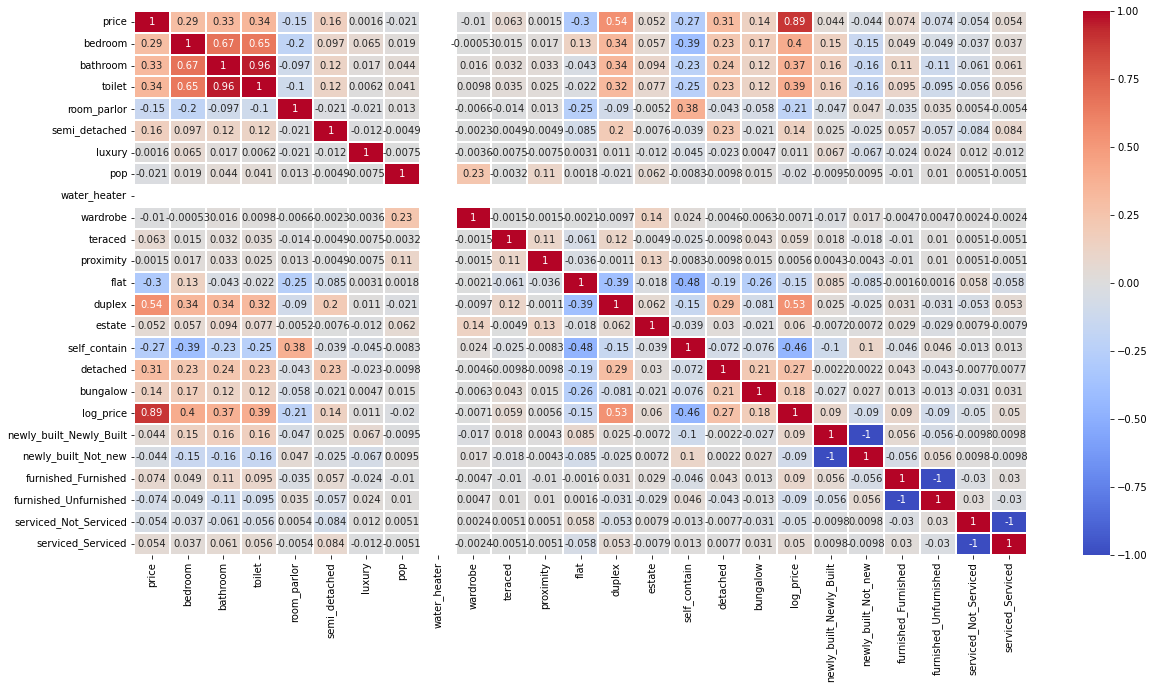

In [13]:
corr = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr,cmap='coolwarm',linewidths=2.0, annot=True)

In [14]:
# one hot encode street column

df = pd.get_dummies(df, columns = ['street'])

In [15]:
df.columns

Index(['title', 'address', 'price', 'bedroom', 'bathroom', 'toilet',
       'description', 'room_parlor', 'semi_detached', 'luxury', 'pop',
       'water_heater', 'wardrobe', 'teraced', 'proximity', 'flat', 'duplex',
       'estate', 'self_contain', 'detached', 'bungalow', 'log_price',
       'newly_built_Newly_Built', 'newly_built_Not_new', 'furnished_Furnished',
       'furnished_Unfurnished', 'serviced_Not_Serviced', 'serviced_Serviced',
       'street_Academy', 'street_Adamasingba', 'street_Agbowo', 'street_Agodi',
       'street_Akala Estate', 'street_Akala express', 'street_Akobo',
       'street_Alakia', 'street_Alalubosa', 'street_Apata', 'street_Apete',
       'street_Basorun', 'street_Bodija', 'street_Carlton Gate',
       'street_Elewuro', 'street_Eleyele', 'street_Heritage Estate',
       'street_Idishin', 'street_Ikolaba', 'street_Ire Akari', 'street_Iwo Rd',
       'street_Iyaganku', 'street_Jericho', 'street_Kolapo Ishola',
       'street_Kuola', 'street_Lagelu Estate', 

### Model Building

In [16]:
# prepare the data for model building

X = df.drop(['price','address','title','newly_built_Not_new',
             'furnished_Unfurnished','serviced_Not_Serviced','water_heater','title','address','description','log_price'], axis=1)

y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
def rmse(a, b):
    """_summary_

    Args:
        a (variable): _The predicted Y_
        b (variable): _THhe actual Y from the test set_

    Returns:
        _RMSE: _Root mean square error of our prediction_
    """    
    return mean_squared_error(a,b, squared =False)

In [29]:
# Train a base Xgboost regressor model

xgb_model = XGBRegressor(random_state = 40)
xgb_model.fit(X_train, y_train)

y_predd = xgb_model.predict(X_test)

rmse(y_predd, y_test)

0.47453480719383034

In [30]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predd)

0.621152245903472

In [20]:
xgb_model = XGBRegressor(reg_alpha=0.5, reg_lambda=0.5)
xgb_model.fit(X_train, y_train)

y_preddd = xgb_model.predict(X_test)

rmse(y_predd, y_test)

0.47453480719383034

#### Feature Importance

In [21]:
important_df = pd.DataFrame({
    'feature' : X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance',ascending = False)

In [22]:
important_df.head(10)

,feature,importance
11,duplex,0.185018
13,self_contain,0.076984
2,toilet,0.064526
42,street_Kolapo Ishola,0.056875
41,street_Jericho,0.040586
0,bedroom,0.034082
28,street_Apata,0.031436
30,street_Basorun,0.029797
26,street_Alakia,0.028890
22,street_Agodi,0.026781


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

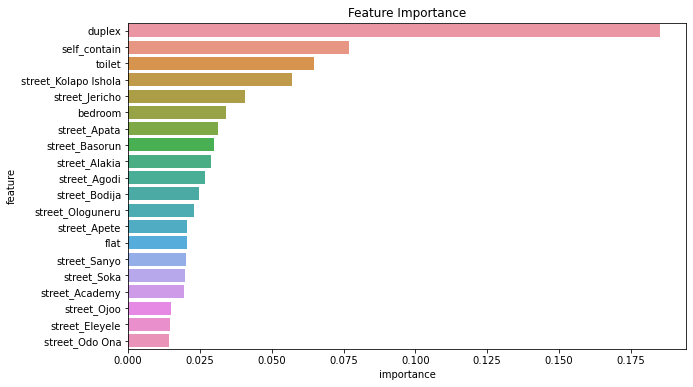

In [23]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data = important_df.head(20), x = 'importance', y = 'feature')


In [24]:
important_df['feature'].unique()

array(['duplex', 'self_contain', 'toilet', 'street_Kolapo Ishola',
       'street_Jericho', 'bedroom', 'street_Apata', 'street_Basorun',
       'street_Alakia', 'street_Agodi', 'street_Bodija',
       'street_Ologuneru', 'street_Apete', 'flat', 'street_Sanyo',
       'street_Soka', 'street_Academy', 'street_Ojoo', 'street_Eleyele',
       'street_Odo Ona', 'street_Carlton Gate', 'proximity', 'bungalow',
       'street_Ring', 'street_Oke ado', 'street_Ikolaba', 'street_Kuola',
       'street_other', 'street_Oluyole', 'street_Iwo Rd',
       'street_New Garage', 'street_Samonda', 'street_Akala express',
       'street_challenge', 'street_Oje', 'bathroom', 'detached',
       'street_Onireke Gra', 'street_Oremeji', 'street_Akobo',
       'serviced_Serviced', 'newly_built_Newly_Built', 'room_parlor',
       'furnished_Furnished', 'street_Akala Estate', 'luxury', 'teraced',
       'street_Elewuro', 'street_Agbowo', 'street_Alalubosa',
       'semi_detached', 'estate', 'street_Heritage Estate

In [25]:
feature_df = df[['duplex', 'self_contain', 'toilet', 'street_Kolapo Ishola',
       'street_Jericho', 'bedroom', 'street_Apata', 'street_Basorun',
       'street_Alakia', 'street_Agodi', 'street_Bodija',
       'street_Ologuneru', 'street_Apete', 'flat', 'street_Sanyo',
       'street_Soka', 'street_Academy', 'street_Ojoo', 'street_Eleyele',
       'street_Odo Ona','log_price']]

f_X = feature_df.drop(['log_price'], axis=1)
f_y = feature_df['log_price']

X_trainn, X_val, train_targets, val_targets = train_test_split(f_X, f_y, test_size=0.2, random_state=42)


xgb_model = XGBRegressor()
xgb_model.fit(X_trainn, train_targets)

y_predd_f = xgb_model.predict(X_val)

rmse(y_predd_f, val_targets)

0.4930053498869337

### Hyparameter Optimization

In [26]:
X_train, X_val, train_targets, val_targets = train_test_split(X, y, test_size = 0.2)
from sklearn.metrics import r2_score

def test_params(**params):
    """_Takes several parameters, perform a xgboost regression and return train and validation rmse_
    """    
    model = XGBRegressor(n_jobs = -1, random_state = 42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    y_predd_f = model.predict(X_val)
    scores = r2_score(val_targets, y_predd_f)
    print('Train RMSE: {}, Validation RMSE: {}, r2_score: {}'.format(train_rmse, val_rmse, scores))

In [27]:
ests = range(10, 200, 10)

for est in ests:
    print(f'for n_estimator = {est}')
    test_params(n_estimators = est)

for n_estimator = 10
Train RMSE: 0.588143569944507, Validation RMSE: 0.6160273497650296, r2_score: 0.4135395731165269
for n_estimator = 20
Train RMSE: 0.40927581129158236, Validation RMSE: 0.4718459250106934, r2_score: 0.6559360731737922
for n_estimator = 30
Train RMSE: 0.39192307954822364, Validation RMSE: 0.47003630634324584, r2_score: 0.658570113356288
for n_estimator = 40
Train RMSE: 0.38251056955034063, Validation RMSE: 0.4719062852060336, r2_score: 0.6558480398007152
for n_estimator = 50
Train RMSE: 0.3761966322258521, Validation RMSE: 0.4750452233958329, r2_score: 0.6512544815459287
for n_estimator = 60
Train RMSE: 0.3659053271005429, Validation RMSE: 0.4736937736033799, r2_score: 0.6532359419234837
for n_estimator = 70
Train RMSE: 0.3599744721916915, Validation RMSE: 0.47599489367545306, r2_score: 0.6498587226392541
for n_estimator = 80
Train RMSE: 0.3578866135346188, Validation RMSE: 0.47917406036871896, r2_score: 0.6451659207313061
for n_estimator = 90
Train RMSE: 0.354575273

In [28]:
depths = range(1, 20, 1)

for depth in depths:
    print(f'for max_depth = {depth}')
    test_params(max_depth = depth, n_estimators = 20)

for max_depth = 1
Train RMSE: 0.5202167859861048, Validation RMSE: 0.5420428201076309, r2_score: 0.5459476617646088
for max_depth = 2
Train RMSE: 0.4832006966386852, Validation RMSE: 0.519903616956126, r2_score: 0.5822808343516377
for max_depth = 3
Train RMSE: 0.4581059841976032, Validation RMSE: 0.5026767351418275, r2_score: 0.6095042643136281
for max_depth = 4
Train RMSE: 0.438641948211667, Validation RMSE: 0.48170741559911834, r2_score: 0.6414040433403045
for max_depth = 5
Train RMSE: 0.42592459495982876, Validation RMSE: 0.47927074519640595, r2_score: 0.6450227137600385
for max_depth = 6
Train RMSE: 0.40927581129158236, Validation RMSE: 0.4718459250106934, r2_score: 0.6559360731737922
for max_depth = 7
Train RMSE: 0.3967798513420011, Validation RMSE: 0.474041246070277, r2_score: 0.6527270259876261
for max_depth = 8
Train RMSE: 0.3888087659947254, Validation RMSE: 0.4706989735466958, r2_score: 0.6576067244681087
for max_depth = 9
Train RMSE: 0.3849408480397366, Validation RMSE: 0.47

In [29]:
l_rates = [x/100 for x in range(30,39)]

for l_rate in l_rates:
    print(f'for learning rate = {l_rate}')
    test_params(learning_rate = l_rate, n_estimators = 20, max_depth = 9)

for learning rate = 0.3
Train RMSE: 0.3849408480397366, Validation RMSE: 0.4786076352670979, r2_score: 0.6460043139335757
for learning rate = 0.31
Train RMSE: 0.37284086558394886, Validation RMSE: 0.47455983345807373, r2_score: 0.6519667972382612
for learning rate = 0.32
Train RMSE: 0.3734745646818766, Validation RMSE: 0.47625337210985835, r2_score: 0.6494783465323717
for learning rate = 0.33
Train RMSE: 0.376733010701901, Validation RMSE: 0.47300899014361414, r2_score: 0.6542377986792154
for learning rate = 0.34
Train RMSE: 0.37914536076715866, Validation RMSE: 0.47474576839822324, r2_score: 0.6516940214771665
for learning rate = 0.35
Train RMSE: 0.3621420683396842, Validation RMSE: 0.47099117784238403, r2_score: 0.6571814852128955
for learning rate = 0.36
Train RMSE: 0.366711465606263, Validation RMSE: 0.4816980700151298, r2_score: 0.6414179574135087
for learning rate = 0.37
Train RMSE: 0.3615977112760166, Validation RMSE: 0.47974813459775617, r2_score: 0.6443151938687828
for learnin

In [35]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# create a parameter grid to search over
param_grid =  {
    'n_estimators': [30, 40, 60],
    'max_depth': [3, 7, 8],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
}

model = XGBRegressor(n_jobs = -1, random_state = 42)

# create a GridSearchCV object to perform the hyperparameter search
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,verbose = 2)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters found during the search
print(grid_search.best_params_)

# use the best hyperparameters to train a final model
best_regressor = XGBRegressor(**grid_search.best_params_)
best_regressor.fit(X_train, y_train)

# evaluate the final model on the test set
score = best_regressor.score(X_test, y_test)
print(f"Test score: {score:.2f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 40, 'subsample': 1.0}
Test score: 0.58


In [33]:
# compare our model to some base line model

med = np.median(train_targets)

# Use the median as the base prediction for all samples
base_pred = [med] * len(train_targets)

# Calculate the root mean squared error (RMSE) of the base prediction
base_rmse = np.sqrt(np.mean((train_targets - base_pred) ** 2))
base_rmsle = rmsle(train_targets, base_pred)
base_mae = mean_absolute_error(train_targets, base_pred)


metrics = [base_rmse, base_mae,base_rmsle]
met_label = ['base_rmse', 'base_mae', 'base_rmsle']

for metric, label in zip(metrics, met_label):
    print(f'{label} : {metric}')

base_rmse : 0.7713189514908994
base_mae : 0.5933704298514284
base_rmsle : 0.053183915815265034


### Model Prediction

In [31]:
column_names = X_train.columns

# Create a new empty DataFrame with the same column names as the existing DataFrame
input_data = pd.DataFrame(columns=column_names)


def insert_row_with_values(df, bedroom, bathroom, toilet, *column_names):
    # Get the number of columns in the DataFrame
    num_columns = len(df.columns)
    
    # Create a new row of data with the value 0 in every column
    new_row = [0] * num_columns
    
    # Set the value to 1 for the specified columns
    for col in column_names:
        new_row[df.columns.get_loc(col)] = 1
    
    # Set the value of d, e, and f in the appropriate columns
    new_row[df.columns.get_loc('bedroom')] = bedroom
    new_row[df.columns.get_loc('bathroom')] = bathroom
    new_row[df.columns.get_loc('toilet')] = toilet
    
    # Insert the new row into the DataFrame
    df.loc[len(df)] = new_row
    
    return df

insert_row_with_values(input_data, 4,5,5,'duplex', 'street_Kolapo Ishola','estate','newly_built_Newly_Built','pop')

,bedroom,bathroom,toilet,room_parlor,semi_detached,luxury,pop,wardrobe,teraced,proximity,...,street_Onireke Gra,street_Oremeji,street_Orogun,street_Ring,street_Samonda,street_Sanyo,street_Soka,street_Yemetu,street_challenge,street_other
0,4,5,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.columns.nunique() == input_data.columns.nunique()

True

In [32]:
pred = xgb_model.predict(input_data)

print(np.exp(pred))

[2338936.5]


In [33]:
import pickle

pickle.dump(xgb_model,open('xgb_model.pkl', 'wb'))

In [36]:
pickled_model = pickle.load(open('xgb_model.pkl', 'rb'))

In [37]:
X_train.columns

Index(['bedroom', 'bathroom', 'toilet', 'room_parlor', 'semi_detached',
       'luxury', 'pop', 'wardrobe', 'teraced', 'proximity', 'flat', 'duplex',
       'estate', 'self_contain', 'detached', 'bungalow',
       'newly_built_Newly_Built', 'furnished_Furnished', 'serviced_Serviced',
       'street_Academy', 'street_Adamasingba', 'street_Agbowo', 'street_Agodi',
       'street_Akala Estate', 'street_Akala express', 'street_Akobo',
       'street_Alakia', 'street_Alalubosa', 'street_Apata', 'street_Apete',
       'street_Basorun', 'street_Bodija', 'street_Carlton Gate',
       'street_Elewuro', 'street_Eleyele', 'street_Heritage Estate',
       'street_Idishin', 'street_Ikolaba', 'street_Ire Akari', 'street_Iwo Rd',
       'street_Iyaganku', 'street_Jericho', 'street_Kolapo Ishola',
       'street_Kuola', 'street_Lagelu Estate', 'street_Mokola',
       'street_Molete', 'street_Moniya', 'street_New Garage', 'street_Odo Ona',
       'street_Oje', 'street_Ojoo', 'street_Ojurin', 'street_Ok